### ToDo
* changing resource state 
* changing setup for each op 
    * may not required as you have the current operation with the req setup
    * and we do not consider setup times.
* monitoring the basics
* Material (Charge, Qualität, usw)
* Vorgänger (und Nachfolger) auf der Maschine speichern (vollständige Historie) --> Erweiterung: Stack/Queue mit "x Elementen" oder einen "x Zeitraum"
* alternative Maschine aus Maschinengruppe nutzen (optional?)
* Giffler - offene Operationen für die Inferencing
* run-event selbst bauen warten bis zum Endschritt 


Wie macht man Effekte sichtbar?
Qualitätsstufen von Materialen

In [5]:
from causal.causal_model_causal_non_causal import CausalModelCBN
from plan.GifflerThompson import GifflerThompson
from factory.Operation import Operation
from generators.jobs_data_generator import JobsDataGenerator
from plan.PriorityRules import calculate_dynamic_priority, calculate_fcfs_priority

# Beispielhafte Datenstruktur
# Produkt, Arbeitsgang, Maschinengruppe, Tool, geplante Dauer, Nachfolger
template_jobs_data = [
    ['p1', 1, 'a1', 1, 30, 4],
    ['p1', 2, 'a2', 1, 45, 4],
    ['p1', 3, 'a1', 2, 15, 4],
    ['p1', 4, 'a3', 1, 15, -1],
    ['p2', 1, 'a1', 1, 15, 3],
    ['p2', 2, 'a4', 2, 45, 3],
    ['p2', 3, 'a3', 2, 15, 5],
    ['p2', 4, 'a2', 1, 30, 5],
    ['p2', 5, 'a4', 1, 15, -1],
    
#    ['p1', 1, 'a1', 17, 2],
#    ['p1', 2, 'a2', 30, 4],
#    ['p1', 3, 'a3', 14, 4],
#    ['p1', 4, 'a4', 15, 5],
#    ['p1', 5, 'a5', 25, -1],
#    ['p2', 1, 'a1', 13, 3],
#    ['p2', 2, 'a3', 15, 3],
#    ['p2', 3, 'a2', 10, 4],
#    ['p2', 4, 'a6', 20, -1],
]

generator = JobsDataGenerator(template_jobs_data)
num_instances = 150  # Number of new instances to generate
relation = {'p1': 0.5, 'p2': 0.5}  # Relation of each product type

jobs_data = generator.generate_jobs_data(num_instances, relation)

# Maschinenpools definieren
# id, number, tools 
machine_pools_data = [
    ['a1', 1, [1,2,3]],
    ['a2', 1, [1,2,3]],
    ['a3', 1, [1,2,3]],
    ['a4', 1, [1,2,3]],
#    ['a5', 1, [1,2,3]],
#    ['a6', 1, [1,2,3]],
]

# Konvertiere die jobs_data in Operation-Objekte
operations_causal = [Operation(*data) for data in jobs_data]
operations_non_causal = [Operation(*data) for data in jobs_data]
operations_non_avg_causal = [Operation(*data) for data in jobs_data]

# causal model
observed_data = []

csv_file = 'data/observed_data.csv'
model = CausalModelCBN(csv_file)
# Causal model for simulation
# define an inference rule    
def simulation_inference(operation: Operation, tool) -> int:
 
    # 1. Preperation step
    #has_lots_operations = len(operation.predecessor_operations) > 1
    #is_shorter_than_15 =  operation.plan_duration < 15
    #filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    #one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    
    # 2. Infer step
    inferenced_variables = model.infer_duration(True, operation, tool)

    # 3. Calculation step
    new_duration = round(operation.duration * inferenced_variables['delay'],0)
    
    # Save for causal learning
    observed_data.append([tool, inferenced_variables['machine_status'], inferenced_variables['pre_processing'], inferenced_variables['delay']])

    print(f"Operation duration was: {operation.duration} and has been changed to {new_duration}")
    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference(operation: Operation, tool) -> int:
        
    # 2. Infer step
    inferenced_variables = model.infer_duration(False, operation, tool)

    new_duration = round(operation.duration * inferenced_variables['delay'],0)

    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference_non(operation: Operation, tool) -> int:
    return operation.duration

def plan_inference_with_avg_duration(operation: Operation, tool) -> int:
    return operation.duration * model.avg_duration

#hodgens = HodgsonMooreAlgorithm()
#hodgens_schedule = hodgens.schedule_jobs(operations_non_causal, machine_pools_data)

# Case 1: Causal Learned Model
gt = GifflerThompson(calculate_dynamic_priority, plan_inference)
gt_causal_schedule = gt.giffen_thompson(operations_causal, machine_pools_data)

# Case 2: Non-Causal Model
non_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_non)
gt_non_causal_schedule = non_causal.giffen_thompson(operations_non_causal, machine_pools_data)

# Case 3: Model with average duration delay
non_avg_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_with_avg_duration)
gt_non_avg_causal_schedule = non_avg_causal.giffen_thompson(operations_non_avg_causal, machine_pools_data)


Set edges by user
Testing combination: Algorithm=exhaustive, Score=K2
Lerne Modell mit exhaustive-Algorithmus und K2-Score
Successful combination: Algorithm=exhaustive, Score=K2
successful_combinations 1


In [13]:
from simulation.Simulator import Simulator
from simulation.Monitoring.BasicMonitor import monitorResource
from functools import partial

# array to store monitored data
data = []

# resource monitor [pre , post] execution
monitor = [None, partial(monitorResource, data)]

sim = Simulator(machine_pools_data
                , operations_non_causal
                , monitor
                , simulation_inference)

sim.env.run(12000)

2040
2730
2160
2775
2445
2115
2505
3240
4185
2700
3555
2820
3600
3165
4035
3255
4080
3480
4440
3570
4485
3795
4830
3855
4875
4170
5265
4260
5310
15
45
90
135
3495
300
450
360
495
675
540
735
975
3660
1020
765
1080
1395
3735
1275
1680
1365
1725
1620
1350
1665
2145
3930
1695
2175
1725
2220
1740
1440
1785
2220
3945
1755
1485
1800
2250
3960
1770
1530
1830
2280
3975
1785
1575
1845
2310
3990
1800
1620
1860
2340
4005
1815
2370
1845
2415
1860
1665
1890
2415
4020
1875
2445
1905
2490
1920
1710
1935
2490
4035
1935
2520
1965
2565
1980
1755
2010
2565
4050
1995
1800
2025
2595
4065
2010
1845
2040
2625
4080
2025
1890
2085
2655
4095
2070
2685
2100
2730
2115
2775
2145
2820
2175
2820
2205
2865
2220
2865
2250
2910
2265
2910
2295
2955
2310
1935
2325
2955
4110
2325
1980
2340
2985
4125
2340
2025
2355
3015
4140
2355
3045
2385
3090
2400
3090
2430
3135
2460
2070
2520
3135
4155
2475
2160
2535
3165
4170
2490
3195
2520
3240
2535
2205
2580
3270
4200
2550
3300
2580
3345
2595
2250
2610
3345
4215
2610
2295
2625
3375
4

## Some statistics to compare the plan

In [14]:
import pandas as pd

def calculate_makespan(df_schedule, schedule_name):
    # Convert the list of operation objects to a DataFrame
    

    # Calculate start and end times for each job
    grouped_schedule = df_schedule.groupby('job_id').agg({'start_time': 'min', 'end_time': 'max'})

    # Calculate the makespan for each job
    grouped_schedule['makespan'] = grouped_schedule['end_time'] - grouped_schedule['start_time']

    # Calculate the average makespan across all jobs
    average_makespan = grouped_schedule['makespan'].mean()

    # Output the results with the schedule name
    print(f"{schedule_name} | {average_makespan} time units")

print(f"Average makespan across all products: ")
# Example usage with named schedules
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_causal_schedule]), 'NonCausal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_causal_schedule]), 'Causal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_avg_causal_schedule]), 'Causal with AVG')
calculate_makespan(pd.DataFrame([op.to_dict_sim() for op in sim.schedule]), 'Sim')


Average makespan across all products: 
NonCausal | 1590.9 time units
Causal | 1790.5 time units
Causal with AVG | 1735.8326696832596 time units
Sim | 1775.08 time units


In [8]:
import math

truth_sim = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])
truth_causal = pd.DataFrame([op.to_dict() for op in gt_causal_schedule])

combined_df = pd.merge(truth_sim, truth_causal, on=['job_id', 'operation_id'], how='outer')

#trouth_sim['diff'] = trouth_sim['duration'] - trouth_sim['plan_duration']
#trouth_causal['diff'] = trouth_causal['plan_duration'] - trouth_causal['duration']
#trouth_sim['sim_causal_dif'] = trouth_causal['plan_duration'] - trouth_sim['duration']


combined_df['diff_sim_truth'] = combined_df['duration_x'] - combined_df['plan_duration_x']
combined_df['diff_causal_truth'] = combined_df['plan_duration_y'] - combined_df['duration_y']
combined_df['diff_causal_sim'] = combined_df['duration_x'] - combined_df['plan_duration_y'] 
combined_df[['duration_x','plan_duration_x', 'diff_sim_truth', 'diff_sim_truth', 'diff_causal_sim']].describe()
# combined_df[combined_df['diff_causal_sim'] > 0].head(1000)



,duration_x,plan_duration_x,diff_sim_truth,diff_sim_truth,diff_causal_sim
count,677.000000,677.000000,677.000000,677.000000,677.000000
mean,27.208272,24.970458,2.237814,2.237814,-0.199409
std,13.698121,12.250432,3.005102,3.005102,4.026921
min,15.000000,15.000000,0.000000,0.000000,-9.000000
25%,15.000000,15.000000,0.000000,0.000000,-3.000000
50%,18.000000,15.000000,0.000000,0.000000,0.000000
75%,36.000000,30.000000,3.000000,3.000000,0.000000
max,54.000000,45.000000,9.000000,9.000000,9.000000


In [9]:
df_observed_data = pd.DataFrame(observed_data, columns=['previous_machine_pause' , 'machine_status', 'pre_processing', 'delay'])
df_observed_data.to_csv(csv_file)

Sim result

/tmp/ipykernel_9126/1685830134.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


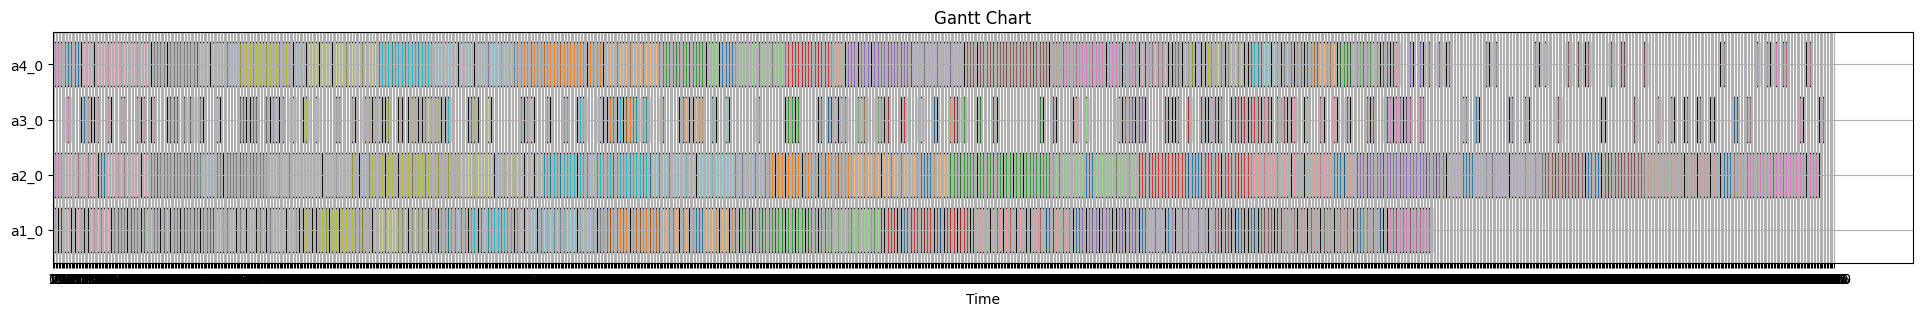

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Erstelle eine Colormap für die job_ids
unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen (optional, falls du das möchtest)
    # ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))

# Grid anzeigen
ax.grid(True)

# Diagramm anzeigen
plt.show()

GT without causal

/tmp/ipykernel_9126/1553617269.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


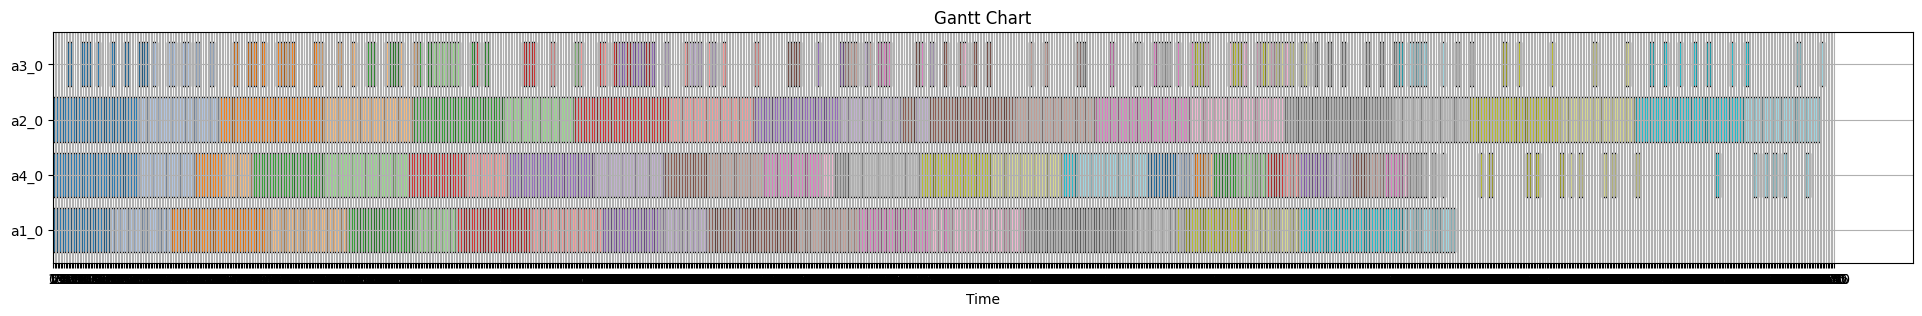

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_non_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))
# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


GT with Causal

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Erstelle eine Colormap für die job_ids
unique_jobs = df['job_id'].unique()
job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Verwende die Farbe für den entsprechenden job_id
    color = job_colors[job_id]
    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color=color, edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')
max_time = df['start_time'].max() + df['duration'].max()  # Determine max time to cover full range
ax.set_xticks(range(0, math.ceil(max_time) + 1, 5))
# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


/tmp/ipykernel_9126/873938610.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  job_colors = {job_id: plt.cm.get_cmap('tab20')(i / len(unique_jobs)) for i, job_id in enumerate(unique_jobs)}


KeyboardInterrupt: 